 # Pokemon Image Clustering #

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
# for other things
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import os

pokemons = []
rootdir = '../data/PokemonData'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        pokemons.append([file, subdir.split('\\')[-1]])
        
print(pokemons[:10])

[['0282b2f3a22745f1a436054ea15a0ae5.jpg', 'Abra'], ['06b9eec4827d4d49b1b4c284308708df.jpg', 'Abra'], ['10a9f06ec6524c66b779ea80354f8519.jpg', 'Abra'], ['1788abb8b51f48509cfac8067bd99e14.jpg', 'Abra'], ['28cfad92ad934d1f9b579cbff4b5d012.jpg', 'Abra'], ['2eb2a528f9a247358452b3c740df69a0.jpg', 'Abra'], ['2fd28e699b7c4208acd1637fbad5df2d.jpeg', 'Abra'], ['32240b108a8140f8b31c495166fc453c.jpg', 'Abra'], ['34532bb006714727ade4075f0a72b92d.jpg', 'Abra'], ['3680c3f65a484c3ba05a7cb93e1d7ae3.jpg', 'Abra']]


In [3]:
pokemon_labels = pd.DataFrame(pokemons, columns = ['FileName', 'Label'])
# credit to https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34
#    for help with image processing
# load the image as a 224x224 array
import matplotlib.image as mpimg
import imghdr
img_list = []
for pokemon in range(len(pokemon_labels)):
    img_path = '../data/PokemonData/'+pokemon_labels.iloc[pokemon]['Label']+'/'+pokemon_labels.iloc[pokemon]['FileName']
    img_type = imghdr.what(img_path)
    if img_type != "png" and img_type != "jpg" and img_type != "jpeg":
        os.remove(img_path)
    else:
        img = load_img(img_path, target_size=(224,224))
        # convert from 'PIL.Image.Image' to numpy array
        img = np.array(img)
        reshaped_img = img.reshape(224,224,3)
        x = preprocess_input(reshaped_img)
        img_list.append([pokemon_labels.iloc[pokemon]['Label'],x])
        #if pokemon_labels.iloc[pokemon]['Label'] in img_dict.keys(): img_dict[pokemon_labels.iloc[pokemon]['Label']].append(np.abs(x))
        #else : img_dict[pokemon_labels.iloc[pokemon]['Label']] = [np.abs(x)]


In [11]:
class img_K_means:
    def __init__(self,img_list,K,dist_func):
        self.imgs       = img_list #dictionary
        self.clustroids = np.asarray(random.sample(self.imgs, K))
        self.centroids  = np.zeros([K,224,224,3])
        self.distances  = np.zeros([K])
        self.clusters   = {}
        self.k = K
        self.dist_func  = dist_func
        self.dist       = 0 #for elbow plots
        for img_tuple in self.clustroids: 
            self.clusters[img_tuple[0]] = [img_tuple]
        
        
    def cluster(self):
        for img_tuple in self.imgs:      # For each data point
            for j, clustroid_tuple in enumerate(self.clustroids):                       # go through each clustroid
                self.distances[j] = self.squared_dist(clustroid_tuple[1],img_tuple[1])  # and calculate distance to clustroid.
            index = np.argmin(self.distances)                            # Get the index of the closest clustroid
            if self.clustroids[index][0] in self.clusters.keys(): self.clusters[self.clustroids[index][0]].append(img_tuple)
            else: self.clusters[self.clustroids[index][0]] = [img_tuple]   #assign to corresponding cluster

                
                #for tuples in self.clusters[self.clustroids[index]]: print(tuples[0])
                #print("one point assigned: ", img_label, ctr)
                
    def compute_centroids(self):
        new_clusters = {}
        
        for index,cluster in enumerate(self.clusters.keys()):
            
            if index>self.k: break #out of bounds
            centroid = np.zeros([224,224,3])
            
            for img_tuple in self.clusters[cluster]: 
                centroid += np.abs(img_tuple[1])
                
            self.centroids[index] = np.abs(centroid)/len(self.clusters[cluster]) #averages the image RGB's in the cluster list
            ctr=0
            clustroid_tuple=["",np.zeros([224,224,3])]
            distances = np.full((len(self.clusters[cluster])),1000000) #start with large distances so min() doesn't grab 0's
            
            for cluster_tuple in self.clusters[cluster]: 
                distances[ctr] = self.squared_dist(cluster_tuple[1],self.centroids[index])
                if distances[ctr] == min(distances): 
                    clustroid_tuple = cluster_tuple
                ctr+=1
                
            if clustroid_tuple[0] == "": #sometimes clustroid won't get filled by this point. Not sure why, so here's my caveman solution
                clustroid_tuple = random.sample(self.imgs,1)
    
            new_clusters[clustroid_tuple[0]] = [clustroid_tuple] #if we get an error here, collision and thats not great
            self.clustroids[index]  = clustroid_tuple
            
        print(self.k, "clusters:")
        
        for i in self.clusters.keys():print(i,len(self.clusters[i]))
            
        self.clusters.clear()
        self.clusters = new_clusters.copy()
        
    def squared_dist(self,img1,img2):
        return np.sqrt(np.sum((img1-img2)**2))
    
    def intensity_dist(self,img1,img2):
        arr = np.zeros([224,224])
        for i in range(224):
            for j in range(224):
                arr[i][j] = np.abs(np.sum(img1[i][j])-np.sum(img2[i][j]))
        return np.sum(arr)
        
    
    def fit(self):
        cloysters = self.clusters.copy()
        for i in range(25):
            self.compute_centroids()
            self.cluster()
            if cloysters == self.clusters: break
            cloysters.clear()
            cloysters = self.clusters.copy()
        self.elbow
        
            
    def predict(self,img_tuple):
        for j, clustroid_tuple in enumerate(self.clustroids):                       # go through each clustroid
            self.distances[j] = self.squared_dist(clustroid_tuple[1],img_tuple[1])  # and calculate distance to clustroid.
        index = np.argmin(self.distances)
        return self.clustroids[index][0] #return label of nearest clustroid
    
    def elbow(self):
        for index,cluster in enumerate(self.clusters.keys()):
            ctr = 0
            for cluster_tuple in self.clusters[cluster]: 
                if ctr>0:
                    self.dist += self.squared_dist(cluster_tuple[1],self.clusters[cluster][0][1])
                ctr+=1 
        self.dist/=len(self.imgs)
        return self.dist
        
                

In [5]:
Ks = [2,5,10,20,50,150]
k_clusters = []
accs       = []
dists      = []
for k in Ks:
    k_cluster = img_K_means(img_list,k,0)
    k_cluster.fit()
    acc = 0
    for i in range(10):
        ind = random.randint(0,len(img_list))
        img = img_list[ind]
        prediction = k_cluster.predict(img)
        if prediction == img[0]: acc+=1
    acc/=10
    accs.append(acc)
    dists.append(k_cluster.dist)
    print("accuracy for 10 random images:",acc)
    for cluster in k_cluster.clusters.keys():
        print("clustroid:",cluster,"number of imgs in this cluster: ",len(k_cluster.clusters[cluster]))
    k_clusters.append(k_cluster)

C:\Users\Muck\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


2 clusters:
Lapras 1
Kabutops 1
2 clusters:
Lapras 3282
Kabutops 3539
2 clusters:
Articuno 4532
Exeggcute 2289
2 clusters:
Onix 5537
Chansey 1284
accuracy for 10 random images: 0.0
clustroid: Onix number of imgs in this cluster:  5537
clustroid: Chansey number of imgs in this cluster:  1284
5 clusters:
Nidorina 1
Abra 1
Tangela 1
Magikarp 1
Scyther 1
5 clusters:
Nidorina 2307
Abra 3274
Tangela 406
Magikarp 170
Scyther 667
5 clusters:
Chansey 1334
Kadabra 808
Lapras 2119
Pidgey 1675
Seel 888
5 clusters:
Chansey 1286
Wartortle 3164
Pidgey 1490
Rhydon 883
5 clusters:
Chansey 1008
Magneton 2589
Pidgey 2104
Rhydon 1122
accuracy for 10 random images: 0.0
clustroid: Chansey number of imgs in this cluster:  1008
clustroid: Magneton number of imgs in this cluster:  2589
clustroid: Pidgey number of imgs in this cluster:  2104
clustroid: Rhydon number of imgs in this cluster:  1122
10 clusters:
Spearow 1
Electabuzz 1
Charizard 1
Raichu 1
Golem 1
MrMime 1
Parasect 1
Jigglypuff 1
Machamp 1
Voltorb 

50 clusters:
Ponyta 2
Rhydon 275
Weezing 457
Parasect 3
Aerodactyl 2
Pidgey 623
Magikarp 150
Kabutops 70
Chansey 419
Sandshrew 23
Dodrio 2
Rhyhorn 105
Wartortle 12
Mewtwo 566
Rapidash 6
Krabby 2
Nidorino 239
Onix 597
Raichu 2
Articuno 2
Bellsprout 98
Gloom 50
Electrode 8
Ninetales 227
Exeggcute 344
Charizard 2
Vulpix 15
Charmeleon 4
Nidoking 59
Diglett 1356
Horsea 5
Jynx 39
Beedrill 5
Lickitung 62
Seel 978
Golem 18
Poliwrath 28
50 clusters:
Ponyta 2
Rhydon 275
Weezing 457
Parasect 3
Aerodactyl 2
Pidgey 473
Electrode 10
Kabutops 65
Chansey 391
Sandshrew 12
Dodrio 2
Rhyhorn 37
Wartortle 12
Mewtwo 392
Rapidash 6
Krabby 2
Nidorino 218
Onix 583
Raichu 2
Articuno 2
Bellsprout 94
Gloom 50
Ninetales 227
Exeggcute 344
Charizard 2
Vulpix 15
Charmeleon 4
Nidoking 54
Diglett 1018
Horsea 4
Jynx 42
Beedrill 2
Lickitung 64
Mew 1925
Golem 18
Grimer 10
Poliwrath 33
Seel 3
50 clusters:
Ponyta 2
Rhydon 275
Weezing 457
Parasect 2
Aerodactyl 2
Pidgey 656
Electrode 8
Kabutops 71
Chansey 412
Sandshrew 75
Dod

50 clusters:
Ponyta 2
Rhydon 295
Horsea 318
Parasect 2
Aerodactyl 2
Pidgey 433
Electrode 8
Kabutops 64
Chansey 392
Sandshrew 42
Dodrio 2
Ditto 28
Wartortle 243
Mewtwo 730
Rapidash 6
Krabby 2
Nidorino 237
Onix 498
Raichu 2
Articuno 2
Bellsprout 84
Gloom 77
Ninetales 270
Exeggcute 364
Charizard 2
Vulpix 17
Charmeleon 4
Nidoking 62
Mew 4
Beedrill 30
Kangaskhan 35
Dratini 5
Rhyhorn 111
Meowth 8
Zapdos 22
Voltorb 27
Cubone 64
Fearow 5
Lickitung 58
Weedle 500
Machoke 1786
Golem 18
accuracy for 10 random images: 0.0
clustroid: Ponyta number of imgs in this cluster:  2
clustroid: Rhydon number of imgs in this cluster:  295
clustroid: Horsea number of imgs in this cluster:  318
clustroid: Parasect number of imgs in this cluster:  4
clustroid: Aerodactyl number of imgs in this cluster:  2
clustroid: Pidgey number of imgs in this cluster:  433
clustroid: Electrode number of imgs in this cluster:  8
clustroid: Kabutops number of imgs in this cluster:  64
clustroid: Chansey number of imgs in this c

150 clusters:
Growlithe 2
Magnemite 2
Caterpie 4
Mewtwo 524
Graveler 48
Rhydon 128
Persian 90
Staryu 4
Vileplume 26
Rapidash 2
Primeape 57
Kingler 2
Exeggcute 321
Koffing 76
Mankey 67
Snorlax 2
Dewgong 161
Onix 547
Gloom 13
Goldeen 28
Poliwhirl 3
Kangaskhan 83
Slowbro 27
Horsea 151
Clefable 39
Wigglytuff 8
Alakazam 4
Marowak 5
Magmar 2
Chansey 277
Machop 68
Poliwag 2
Pidgeotto 30
Haunter 1275
Aerodactyl 3
Butterfree 2
Omanyte 96
Dodrio 2
Pidgey 379
Sandslash 3
Poliwrath 3
Rhyhorn 28
Dragonite 2
Golem 63
Ponyta 2
Hitmonchan 108
Tangela 56
Nidoqueen 93
Charmeleon 2
Pikachu 12
Parasect 39
Articuno 6
Ekans 8
Weezing 211
Cloyster 32
Mew 2
Nidorina 2
Porygon 6
Ninetales 104
Seel 13
Raticate 27
Muk 20
Sandshrew 28
Rattata 3
Venomoth 7
Hitmonlee 3
Eevee 51
Scyther 3
Bulbasaur 61
Lickitung 5
Victreebel 7
Pidgeot 2
Diglett 801
Psyduck 131
Kabuto 11
Weedle 128
Kakuna 29
Gastly 39
Voltorb 26
Vaporeon 6
Weepinbell 38
Doduo 76
Ditto 5
Charmander 13
Gengar 12
Dugtrio 1
Paras 10
Gyarados 1
150 cluster

150 clusters:
Growlithe 2
Magnemite 2
Caterpie 4
Mewtwo 576
Graveler 54
Rhydon 65
Persian 86
Hitmonchan 104
Vileplume 28
Rapidash 2
Primeape 37
Kingler 2
Exeggcute 321
Koffing 76
Snorlax 2
Dewgong 167
Onix 550
Gloom 20
Goldeen 36
Poliwhirl 3
Kangaskhan 87
Slowbro 26
Horsea 160
Clefable 9
Wigglytuff 8
Alakazam 4
Marowak 5
Magmar 2
Chansey 279
Machop 72
Poliwag 2
Pidgeotto 30
Haunter 861
Aerodactyl 3
Butterfree 2
Omanyte 96
Dodrio 2
Pidgey 352
Sandslash 3
Poliwrath 3
Rhyhorn 73
Ponyta 2
Tangela 61
Nidoqueen 116
Charmeleon 2
Pikachu 15
Parasect 81
Articuno 6
Ekans 7
Weezing 218
Pinsir 13
Nidorina 46
Porygon 6
Ninetales 104
Seel 12
Raticate 92
Muk 27
Sandshrew 25
Rattata 4
Venomoth 7
Hitmonlee 3
Eevee 5
Scyther 4
Electrode 10
Lickitung 5
Victreebel 7
Pidgeot 2
Psyduck 137
Gastly 43
Voltorb 28
Kakuna 9
Gyarados 3
Geodude 7
Ditto 7
Dragonite 63
Cubone 63
Weepinbell 60
Staryu 4
Metapod 264
Diglett 856
Spearow 76
Cloyster 14
Dugtrio 2
Weedle 9
Vaporeon 6
Doduo 66
Gengar 49
Paras 29
Charmander 

150 clusters:
Growlithe 2
Magnemite 2
Caterpie 4
Mewtwo 550
Graveler 56
Rhydon 85
Persian 82
Hitmonchan 109
Vileplume 532
Rapidash 2
Primeape 26
Kingler 3
Exeggcute 321
Koffing 75
Snorlax 2
Dewgong 164
Onix 547
Gloom 25
Goldeen 42
Poliwhirl 5
Kangaskhan 87
Slowbro 29
Horsea 160
Clefable 7
Wigglytuff 8
Alakazam 4
Marowak 4
Hitmonlee 3
Chansey 279
Machop 71
Poliwag 2
Pidgeotto 31
Haunter 886
Aerodactyl 2
Butterfree 2
Omanyte 96
Dodrio 2
Pidgey 332
Sandslash 3
Poliwrath 3
Ponyta 2
Tangela 61
Nidoqueen 13
Charmeleon 2
Pikachu 17
Parasect 74
Tentacool 24
Ekans 9
Weezing 221
Pinsir 12
Nidorina 2
Porygon 6
Ninetales 104
Seel 12
Raticate 34
Muk 27
Sandshrew 25
Rattata 11
Venomoth 7
Eevee 5
Scyther 4
Electrode 7
Lickitung 5
Victreebel 11
Pidgeot 2
Psyduck 137
Gastly 44
Voltorb 28
Kakuna 10
Gyarados 3
Geodude 7
Ditto 3
Cubone 57
Golem 326
Staryu 4
Rhyhorn 58
Weedle 243
Cloyster 15
Spearow 146
Dragonite 2
Diglett 223
Articuno 5
Dugtrio 5
Mew 2
Jigglypuff 39
Vaporeon 8
Paras 53
Weepinbell 43
Doduo

In [12]:
for k_cluster in k_clusters:
    print(k_cluster.clusters.keys())
dists1 = []
for k_cluster in k_clusters:
    dists1.append(k_cluster.elbow())

dict_keys(['Onix', 'Chansey'])
dict_keys(['Chansey', 'Magneton', 'Pidgey', 'Rhydon'])
dict_keys(['Chansey', 'Onix', 'Rhydon', 'Kadabra', 'Exeggcute', 'Eevee'])
dict_keys(['Magneton', 'Chansey', 'Venusaur', 'Ditto', 'Moltres', 'Pidgey', 'Poliwag', 'Oddish', 'Rhydon', 'Hitmonlee', 'Victreebel', 'Seel', 'Squirtle', 'Kangaskhan', 'Slowbro'])
dict_keys(['Ponyta', 'Rhydon', 'Horsea', 'Parasect', 'Aerodactyl', 'Pidgey', 'Electrode', 'Kabutops', 'Chansey', 'Sandshrew', 'Dodrio', 'Ditto', 'Wartortle', 'Mewtwo', 'Rapidash', 'Krabby', 'Nidorino', 'Onix', 'Raichu', 'Articuno', 'Bellsprout', 'Gloom', 'Ninetales', 'Exeggcute', 'Charizard', 'Vulpix', 'Charmeleon', 'Nidoking', 'Mew', 'Beedrill', 'Kangaskhan', 'Dratini', 'Rhyhorn', 'Meowth', 'Zapdos', 'Voltorb', 'Cubone', 'Fearow', 'Lickitung', 'Weedle', 'Grimer', 'Golem'])
dict_keys(['Growlithe', 'Magnemite', 'Caterpie', 'Mewtwo', 'Graveler', 'Rhydon', 'Persian', 'Hitmonchan', 'Farfetchd', 'Rapidash', 'Primeape', 'Kingler', 'Exeggcute', 'Koffing', 'Sn

[None, None, None, None, None, None]


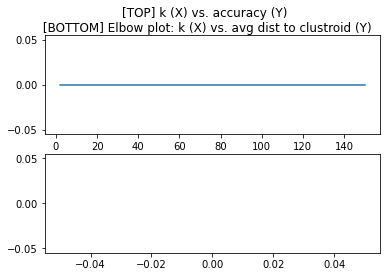

In [13]:
fig, axs = plt.subplots(2)
fig.suptitle("[TOP] k (X) vs. accuracy (Y) \n [BOTTOM] Elbow plot: k (X) vs. avg dist to clustroid (Y) ")
axs[0].plot(Ks, accs)
axs[1].plot(Ks, dists1)
print(dists1)